# Data augmentation
Data generators in this project expect an transformation for data augmentation.

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
import volumentations as V
import tifffile as tif
from skimage.data import astronaut
from pathlib import Path
from sklearn.model_selection import train_test_split

## Image augmentation (2D)

### Image augmentation using `tensorflow`
Trying to transform x/y data together

(512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


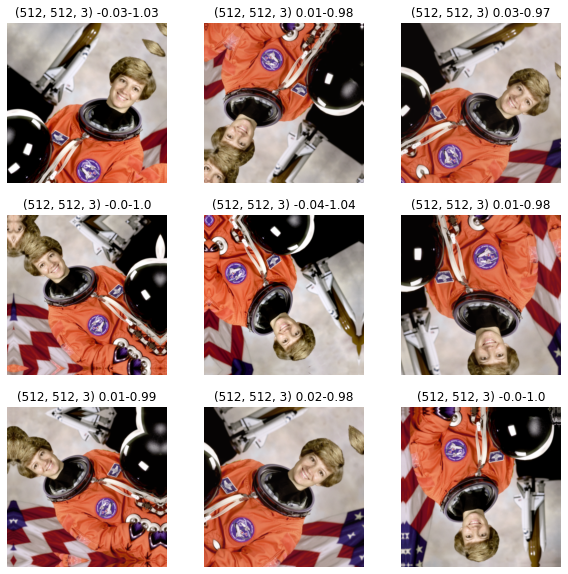

In [109]:
# https://www.tensorflow.org/tutorials/images/data_augmentation
img = astronaut()
print(img.shape)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # silence tf warnings

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomTranslation(height_factor=0.1,
                                      width_factor=0.1,
                                      fill_mode="reflect",
                                      interpolation="bilinear",
                                      seed=None,
                                      fill_value=0.0),  # gives a bunch of converting warning
    tf.keras.layers.RandomRotation(factor=0.2,
                                   fill_mode="reflect",
                                   interpolation="bilinear",
                                   seed=None,
                                   fill_value=0.0),
    tf.keras.layers.RandomZoom(height_factor=0.1,
                               width_factor=None,
                               fill_mode="reflect",
                               interpolation="bilinear",
                               seed=None,
                               fill_value=0.0),
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical",
                               seed=None),
    tf.keras.layers.RandomContrast(factor=0.1,
                                   seed=None),
    tf.keras.layers.Rescaling(1./255)
])

# Add the image to a batch.
image = tf.cast(tf.expand_dims(img, 0), tf.float32)

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    np_img = augmented_image[0].numpy()
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np_img)
    plt.title(str(np_img.shape) + " " + str(round(np_img.min(), 2)) + "-" + str(round(np_img.max(), 2)))
    plt.axis("off")

(512, 512, 3)


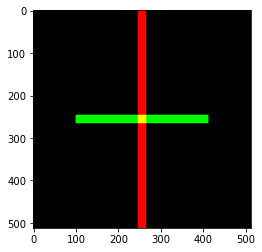

In [110]:
# simple annotation for validation
anno = np.zeros(augmented_image.shape[1:], dtype=np.uint8)
half_len = anno.shape[0]//2
anno[:, half_len-10:half_len+10, 0] = 255
anno[half_len-10:half_len+10, 100:-100, 1] = 255

print(anno.shape)
plt.imshow(anno)
plt.show()

# Add the annotation to a batch.
annotation = tf.cast(tf.expand_dims(anno, 0), tf.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


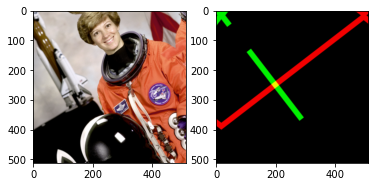

In [111]:
x = data_augmentation(image, training=True)[0]
y = data_augmentation(annotation)[0]

plt.subplot(121)
plt.imshow(x)
plt.subplot(122)
plt.imshow(y)
plt.show()

This preprocessing sequence can be added to a Keras model and will only be considered when fitting data (not during prediction)  
  
Now that's nice, but I can't be bothered to understand `tf.data.Dataset` data loading functions to be able to transform annotation as well.

### Image augmentation using `albumentations`
Python module for image augmentation which I'll be using for training since I know how to use it, it's fast and is similar to volumentations module which I'll use for volume augmentation.

In [112]:
img_transform = A.Compose([
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1),
    A.ElasticTransform(p=1),
    A.Rotate(limit=60, interpolation=1, border_mode=4, value=None, mask_value=None, p=1),
    #A.RandomBrightnessContrast(p=0.2),
])

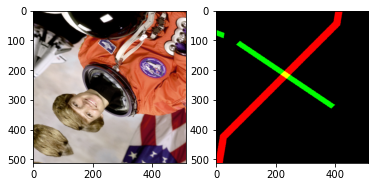

In [113]:
data = {'image': img,
        'mask': anno}
        
aug_data = img_transform(**data)
        
# fill batches
x, y = aug_data['image'], aug_data['mask']

plt.subplot(121)
plt.imshow(x)
plt.subplot(122)
plt.imshow(y)
plt.show()

GridDropout is another transformation that will be useful for unsupervised training for inpainting

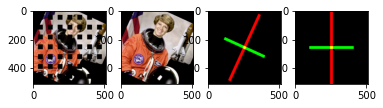

In [114]:
img_grid_drop = A.Compose([
    A.Rotate(limit=30, interpolation=1, border_mode=0, value=None, mask_value=None, p=1),
    A.GridDropout(0.5, unit_size_min=50, unit_size_max=100, holes_number_x=2, random_offset=True, p=1)
])

data = {'image': img,
        'masks':  [img, anno],
        'test':  anno}
aug_data = img_grid_drop(**data)

plt.subplot(141)
plt.imshow(aug_data['image'])
plt.subplot(142)
plt.imshow(aug_data['masks'][0])
plt.subplot(143)
plt.imshow(aug_data['masks'][1])
plt.subplot(144)
plt.imshow(aug_data['test'])
plt.show()

Conveniently, transformations are only applied to image, not the masks :D

We can also see that it's possible to have multiple masks, and that random keys in data dictionnary aren't processed

GridDropout as many params. Here are some usefuls ones:
- ratio : don't touch it, 0.5 seems good
- unit_size_min : min length of square
- unit_size_min : max length of square
- holes_number_x : number of square on X (not really compatible with above)
- holes_number_y : number of square on Y (same ^)
- random_offset : not really useful because of next param

## Volume augmentation

### Volume augmentation using `volumentations`
Python module for volume augmentation, based of `albumentations` module

In [115]:
# figure with all img over z axis
def show_volume(volume):
    plt.figure(figsize=(10,20))
    for i in range(volume.shape[0]):
        plt.subplot(volume.shape[0], 3, i+1)
        plt.title('index ' + str(i))
        plt.title(str(i) + ":" + str(round(volume.min(), 2)) + "-" + str(round(volume.max(), 2)) + str(volume.shape))
        plt.imshow(volume[i])
    plt.show()

annotation shape (5, 512, 512, 3)


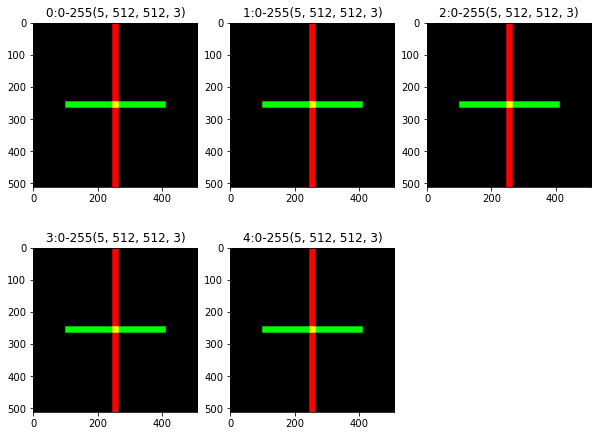

In [116]:
# simple annotation for validation
anno_vol = np.stack([anno] * 5, axis=0)

print('annotation shape', anno_vol.shape)

show_volume(anno_vol)

volume shape (5, 512, 512, 3)


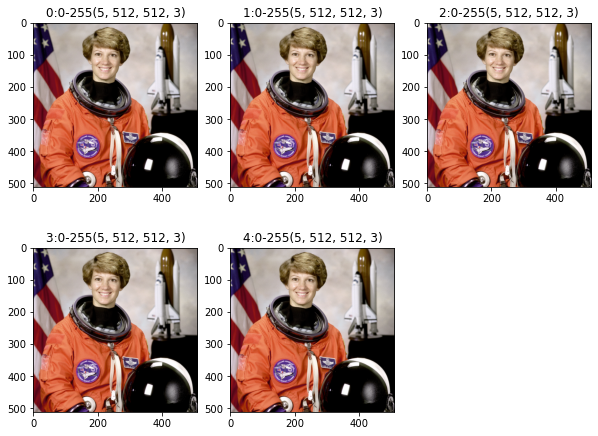

In [117]:
volume = np.stack([img] * 5, axis=0)
print('volume shape', volume.shape)

show_volume(volume)

In [118]:
# elastic transform are nice, but very slow
vol_transform = V.Compose([
    V.Flip(axis=1, p=1),
    V.Flip(axis=2, p=1),
    #V.ElasticTransform((0, 0.25), interpolation=2, p=0.1),
    V.ElasticTransformPseudo2D(alpha=25, sigma=5, alpha_affine=1, p=1),
    V.Rotate(x_limit=(-90,90), interpolation=3, border_mode='reflect', p=1),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(5, 512, 512, 3) -20.607944 270.5048


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


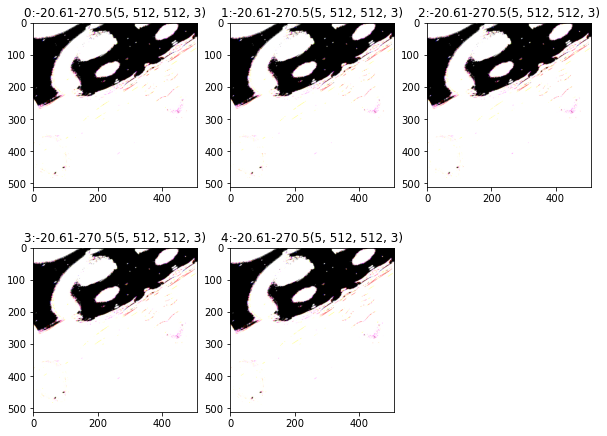

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(5, 512, 512, 3) 0.0 255.0


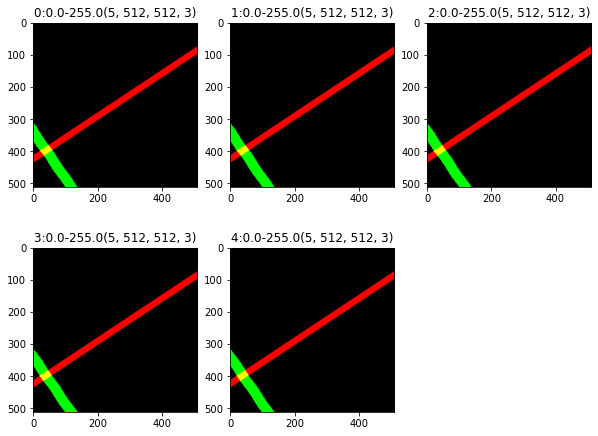

In [119]:
data_vol = {'image': volume,
            'mask':  anno_vol}
        
aug_vol_data = vol_transform(**data_vol)
        
# fill batches
aug_vol_x, aug_vol_y = aug_vol_data['image'], aug_vol_data['mask']

print(aug_vol_x.shape, aug_vol_x.min(), aug_vol_x.max())
show_volume(aug_vol_x)
print(aug_vol_y.shape, aug_vol_y.min(), aug_vol_y.max())
show_volume(aug_vol_y)

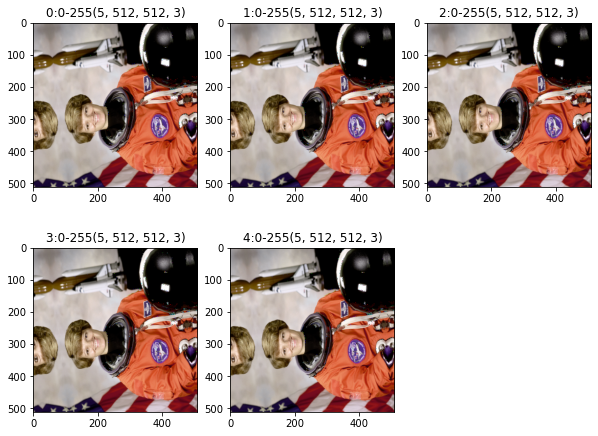

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


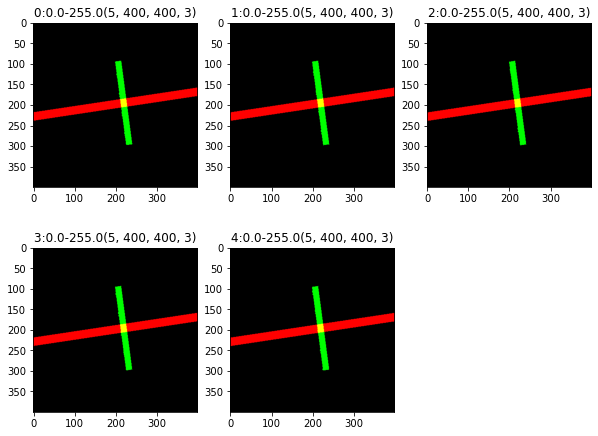

In [44]:
# the volume is transformed, but intensity range goes all over the place
# why? because the input is converted in float, but we can simply convert back and forget about it
norm_x = aug_vol_x.copy() - aug_vol_x.min()
norm_x = np.round(norm_x * 255 / norm_x.max()).astype(np.uint8)

show_volume(aug_vol_x.astype(np.uint8))
show_volume(aug_vol_y)

Again, what about grid dropout?

(5, 512, 512, 3) 0.0 1.0 (5, 512, 512, 3) 0.0 1.0
(5, 512, 512, 3) 0.0 1.0 (5, 512, 512, 3) 0.0 1.0


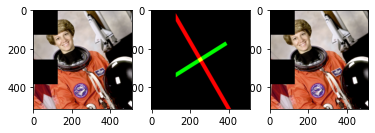

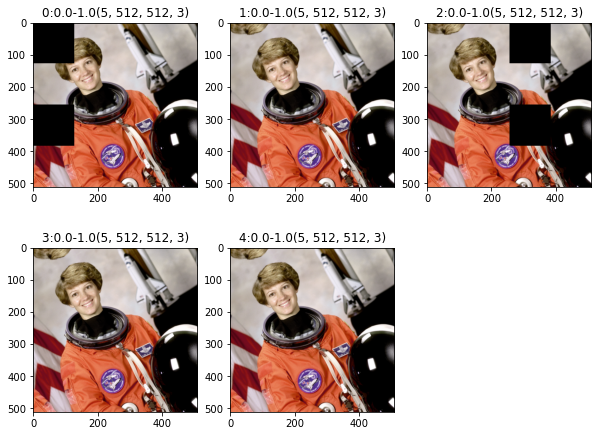

In [183]:
vol_grid_drop = V.Compose([
    #V.Rotate(x_limit=(-30,30), interpolation=1, border_mode='constant', p=1),
    V.Rotate(x_limit=(30,30), interpolation=1, border_mode='reflect', p=1),
    V.GridDropout(0.5, holes_number_x=2, holes_number_y=2, holes_number_z=2, p=1)
], targets=[['image','mask','test']])

bigger_x = np.concatenate([volume]*1, axis=0).astype(float) / volume.max()
bigger_y = np.concatenate([anno_vol]*1, axis=0).astype(float) / anno_vol.max()

print(bigger_x.shape, bigger_x.min(), bigger_x.max(),
      bigger_y.shape, bigger_y.min(), bigger_y.max())

data = {'image': bigger_x,
        'mask' : bigger_y,
        'test':  bigger_x}
aug_data = vol_grid_drop(**data)

print(aug_data['image'].shape, aug_data['image'].min(), aug_data['image'].max(),
      aug_data['mask'].shape, aug_data['mask'].min(), aug_data['mask'].max())

z = 0
plt.subplot(131)
plt.imshow(aug_data['image'][z])
plt.subplot(132)
plt.imshow(aug_data['mask'][z])
plt.subplot(133)
plt.imshow(aug_data['test'][z])
plt.show()

show_volume(aug_data['image'])

## Example with our data
Let's try on our volumes

Training dataset
-nb of volumes : 75 / 75
Validation dataset
-nb of volumes : 19 / 19
Testing dataset
-nb of volumes : 6 / 6

(48, 96, 96) (48, 96, 96, 3)
Base


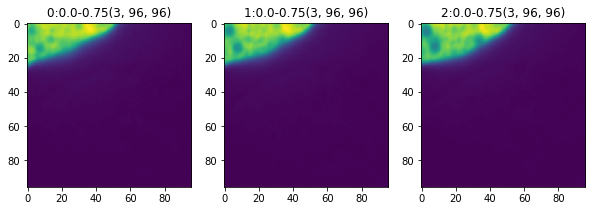

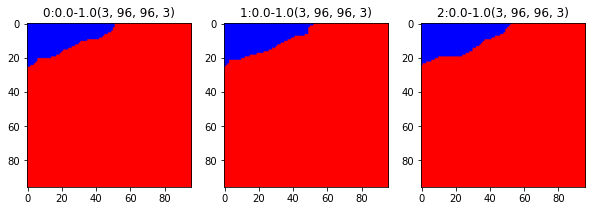

Augmentation


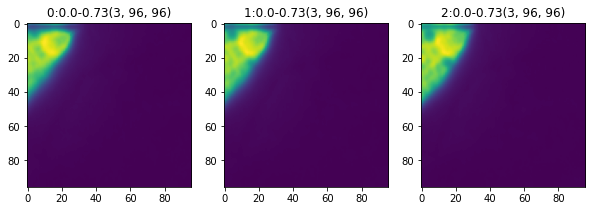

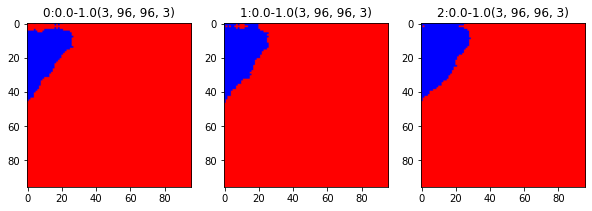

In [13]:

# validate dataset is present
data_folder = "../data"  # folder where downloads and dataset will be put
dataset_folder = data_folder + "/dataset"
output_folder = data_folder + "/output"
input_folder  = dataset_folder + "/input_p"
target_folder = dataset_folder + "/target_p"
model_path = data_folder + "/model/unet3D.h5"
test_volume = data_folder + "/" + dataset_folder + "/input/slik3.tif"
test_target = data_folder + "/" + dataset_folder + "/target/slik3.tif"

# split data between training, validation and test
x_data = []
x_test = []
for f in os.listdir(input_folder):
    if Path(test_volume).name.split('.')[0] in f.split('_')[0]:
        x_test.append(input_folder + "/" + f)
    else:
        x_data.append(input_folder + "/" + f)
        
y_data = []
y_test = []
for f in os.listdir(target_folder):
    if Path(test_volume).name.split('.')[0] in f.split('_')[0]:
        y_test.append(target_folder + "/" + f)
    else:
        y_data.append(target_folder + "/" + f)            

x_train, x_valid, y_train, y_valid = train_test_split(x_data,
                                                      y_data,
                                                      test_size=0.2,
                                                      random_state=6)

print("Training dataset")
print("-nb of volumes :",
      len(x_train), "/",
      len(y_train))
        
print("Validation dataset")
print("-nb of volumes :",
      len(x_valid), "/",
      len(y_valid))
        
# not using the patch, only the full volume for test for now
print("Testing dataset")
print("-nb of volumes :",
      len(x_test), "/",
      len(y_test))
print()

vol_transform = V.Compose([
    V.Rotate((-90, 90), (0,0), (0, 0), border_mode='reflect', p=1),
    V.RandomRotate90((1, 2), p=1),
    V.Flip(axis=1, p=1),
    V.Flip(axis=2, p=1),
    #V.ElasticTransform((0, 0.25), interpolation=2, p=0.1),
    V.ElasticTransformPseudo2D(alpha=40, sigma=10, alpha_affine=1, p=1),
    #V.Resize([64,64,64], interpolation=1, p=1) # TODO resize broken?
])

i = 33
v = tif.imread(x_train[i])
lb = tif.imread(y_train[i])
print(v.shape, lb.shape)
test = {'image': v,
        'mask':  lb}
        
aug_test = vol_transform(**test)

print('Base')
show_volume(test['image'][11:14])
show_volume(test['mask'][11:14])

print('Augmentation')
show_volume(aug_test['image'][11:14])
show_volume(aug_test['mask'][11:14])

# need to normalize to base intensity

#### Extra validate our transformation work over the entire dataset

In [14]:
# validate transform works for every patches
def transform_dataset_test(x, y, t, limit=5):
    counter = 0
    for i in range(len(x)):
        try:
            v = tif.imread(x[i])
            lb = tif.imread(y[i])
        except Exception as e:
            print('Could not read', t, 'data', x[i], y[i])
            print(e)
            counter += 1
        
        test = {'image': v,
                'mask':  lb}
        
        try:
            aug_test = vol_transform(**test)
        except Exception as e:
            print('Could not transform', t, 'data', x[i], y[i])
            print('x info', v.shape, v.dtype, 'range', v.min(), '-', v.max())
            print('y info', lb.shape, lb.dtype, 'range', lb.min(), '-', lb.max())
            print(e)
            counter += 1
        
        if counter >= limit:
            print('Back to the drawing board')
            break

transform_dataset_test(x_train, y_train, 'training')
transform_dataset_test(x_valid, y_valid, 'validation')
transform_dataset_test(x_test, y_test, 'testing')